<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/RAM_Segmentaci%C3%B3n_de_clientes_bancarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación de clientes bancarios

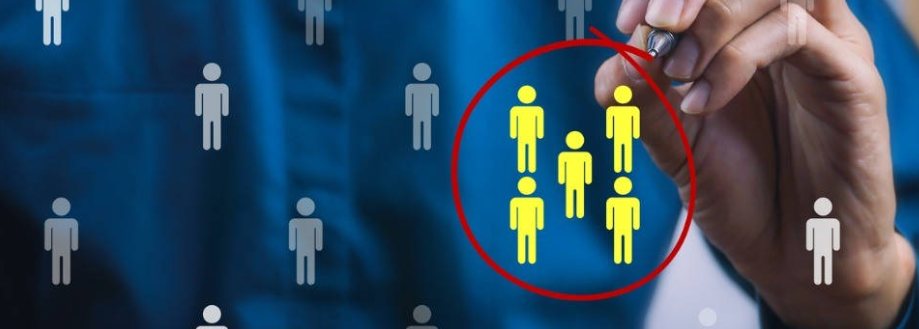

[derechos de la imagen](https://www.unir.net/marketing-comunicacion/revista/analisis-rfm/)

*Jesús Roque Armas Martín - CEIABD*

**Importación de librerías**

In [ ]:
pip install dpc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dpc: filename=dpc-0.1-py3-none-any.whl size=13546 sha256=c17f3d5addfdf30f5a728f8671fdaede71ebdf37b6a1abf85c80fc382e8a040c
  Stored in directory: /root/.cache/pip/wheels/35/4b/f2/7322ae0014f67fd1cf4f5681d619e77e39a2741f6549e5775c
Successfully built dpc


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import dpc

from scipy.spatial.distance import pdist, squareform

import sklearn.neighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from google.colab import files



**Importación de los datos**

In [ ]:
#repositorio = 'https://raw.githubusercontent.com/SalvadorBR/SNS_2324_ACT_4_1/main/bank%2Bmarketing/bank/bank.csv'
repositorio ='https://raw.githubusercontent.com/roquearmas/datasets/main/bank.csv'
df_clientes = pd.read_csv(repositorio, sep=';')
columns =df_clientes.columns.values

Variables de entrada
# Datos de clientes bancarios:

1 - **age**       - *Edad*: Edad del cliente (numérico).

2 - **job**       - *Trabajo*: Tipo de trabajo (categórico: “admin.”, “desconocido”, “desempleado”, “gerencia”, “ama de casa”, “emprendedor”, “estudiante”, “obrero”, “autónomo”, “jubilado”, “técnico”, “servicios”)

3 - **marital**   - *Estado civil*: Estado civil (categórico: “casado”, “divorciado”, “soltero” ;nota: “divorciado” significa divorciado o viudo).

4 - **education** - *Educación*: Nivel educativo (categórico: “desconocido”, “secundaria”, “primaria”, “terciaria”).

5 - **default**   - *Incumplimiento*: ¿Tiene créditos en incumplimiento? (binario): “sí”, “no”.

6 - **balance**   - *Saldo*: Saldo promedio anual, en euros (numérico).

7 - **housing**   - *Vivienda*: ¿Tiene préstamo hipotecario? (binario): “sí”, “no”.

8 - **loan**      - *Préstamo personal*: ¿Tiene préstamo personal? (binario): “sí”, “no”.

# relacionados con el último contacto en la campaña actual

9 - **contact**   - *Contacto*: Tipo de comunicación de contacto (categórico): “desconocido”, “teléfono”, “celular (móvil)”.

10 - **day**      - *Día*: Día del mes del último contacto (numérico).

11 - **month**    - *Mes*: Mes del último contacto (categórico): “ene”, “feb”, “mar”, …, “nov”, “dic”.

12 - **duration** - *Duración*: Duración del último contacto, en segundos (numérico).

# Otros atributos

13 - **campaign** - *Campaña*: Número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto).

14 - **pdays** - *pdías*: Número de días transcurridos desde el último contacto del cliente en una campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente).

15 - **previous** - *Anterior*: Número de contactos realizados antes de esta campaña y para este cliente (numérico).

16 - **poutcome** - *Resultado previo*: Resultado de la campaña de marketing anterior (categórico): “desconocido”, “otro”, “fracaso”, “éxito”.

# Variable de salida (objetivo deseado)

17 - **y** - *Objetivo deseado*: ¿El cliente se ha suscrito a un depósito a plazo? (binario): “yes”, “no”.

In [ ]:
df_clientes

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Extraer el número de valores distintos por columna

In [ ]:
for columna in df_clientes.columns:
    num_valores_unicos = df_clientes[columna].nunique()
    print(f'Número de valores únicos en la columna {columna}: {num_valores_unicos}')

Número de valores únicos en la columna age: 67
Número de valores únicos en la columna job: 12
Número de valores únicos en la columna marital: 3
Número de valores únicos en la columna education: 4
Número de valores únicos en la columna default: 2
Número de valores únicos en la columna balance: 2353
Número de valores únicos en la columna housing: 2
Número de valores únicos en la columna loan: 2
Número de valores únicos en la columna contact: 3
Número de valores únicos en la columna day: 31
Número de valores únicos en la columna month: 12
Número de valores únicos en la columna duration: 875
Número de valores únicos en la columna campaign: 32
Número de valores únicos en la columna pdays: 292
Número de valores únicos en la columna previous: 24
Número de valores únicos en la columna poutcome: 4
Número de valores únicos en la columna y: 2


 Elimino las columnas que considero menos interesantes para realizar el clustering

In [ ]:

# columnas originales ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact','day', 'month', 'duration','campaign', 'pdays', 'previous', 'poutcome', 'y']
# No voy a continuar con las siguientes columnas: 'day', 'month', 'previous', 'pdays'
columns_selected = ['age', 'job', 'marital', 'education','default', 'balance', 'housing', 'loan', 'contact',  'duration','campaign', 'poutcome', 'y']

df_clients = df_clientes[columns_selected]
df_clients

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,79,1,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,220,1,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,185,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,199,4,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,226,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,329,5,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,153,1,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,151,11,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,129,4,other,no



Conversión de variables categóricas a numéricas

In [ ]:
le = LabelEncoder()

pd.options.mode.copy_on_write = True # Para que no muestre el warning

df_clients['job'] = le.fit_transform(df_clients['job'])
df_clients['marital'] = le.fit_transform(df_clients['marital'])
df_clients['education'] = le.fit_transform(df_clients['education'])
df_clients['default'] = le.fit_transform(df_clients['default'])
df_clients['housing'] = le.fit_transform(df_clients['housing'])
df_clients['loan'] = le.fit_transform(df_clients['loan'])
df_clients['contact'] = le.fit_transform(df_clients['contact'])
df_clients['poutcome'] = le.fit_transform(df_clients['marital'])
df_clients['y'] = le.fit_transform(df_clients['y'])

In [ ]:
df_clients

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,poutcome,y
0,30,10,1,0,0,1787,0,0,0,79,1,1,0
1,33,7,1,1,0,4789,1,1,0,220,1,1,0
2,35,4,2,2,0,1350,1,0,0,185,1,2,0
3,30,4,1,2,0,1476,1,1,2,199,4,1,0
4,59,1,1,1,0,0,1,0,2,226,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,0,329,5,1,0
4517,57,6,1,2,1,-3313,1,1,2,153,1,1,0
4518,57,9,1,1,0,295,0,0,0,151,11,1,0
4519,28,1,1,1,0,1137,0,0,0,129,4,1,0


For n_clusters = 2 The average silhouette_score is : 0.832761680980059
For n_clusters = 3 The average silhouette_score is : 0.7492488529348549
For n_clusters = 4 The average silhouette_score is : 0.713312079917465
For n_clusters = 5 The average silhouette_score is : 0.7018292115670886
For n_clusters = 6 The average silhouette_score is : 0.6549387568678101


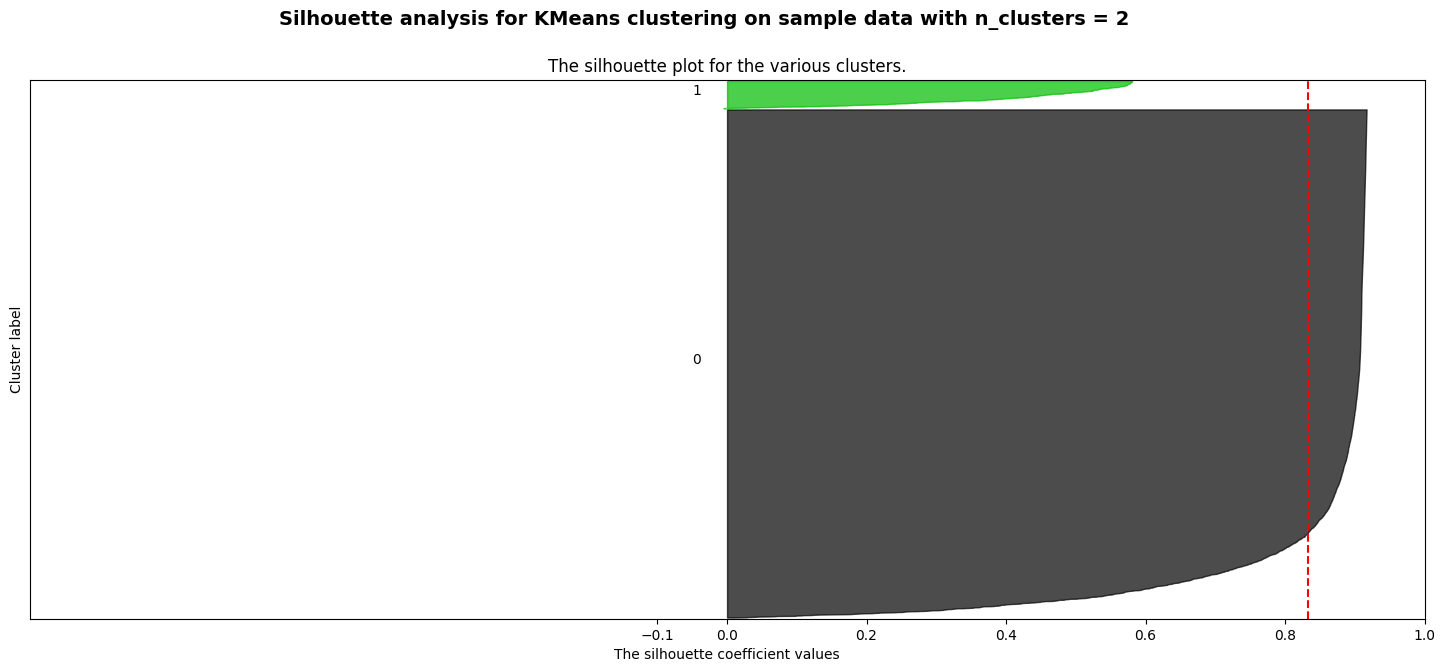

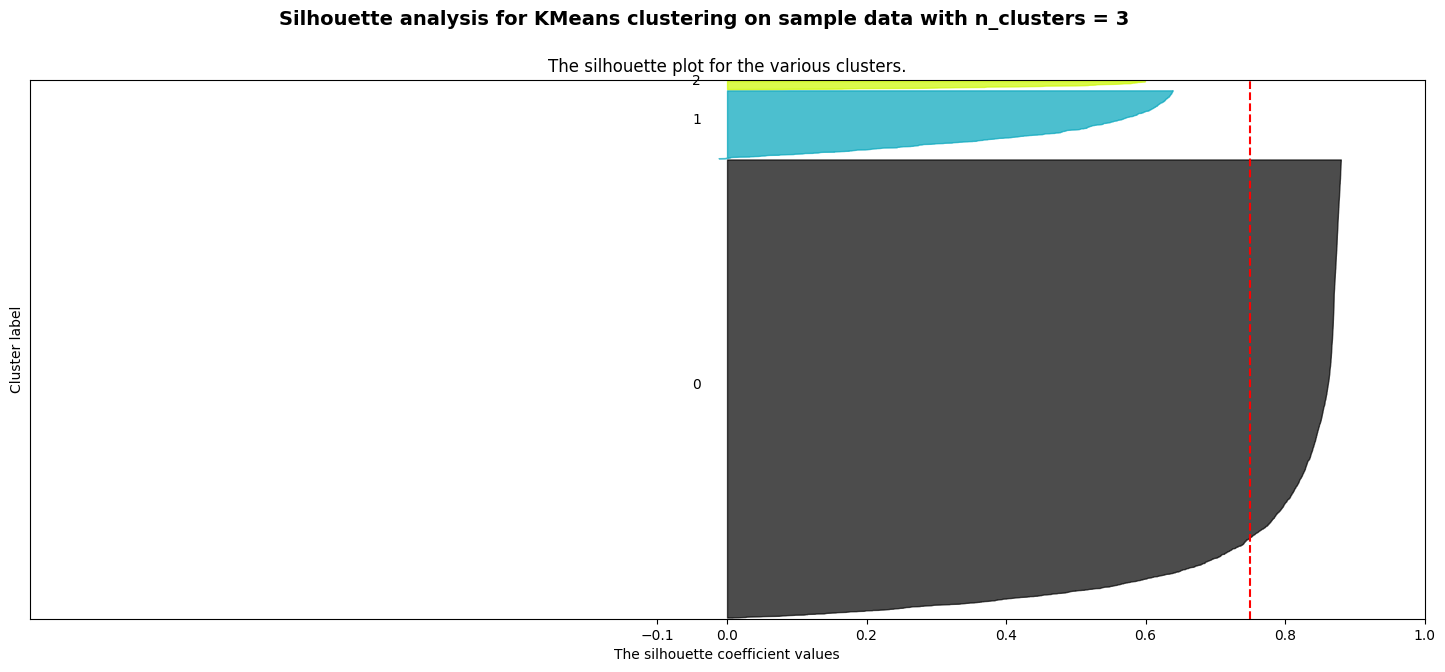

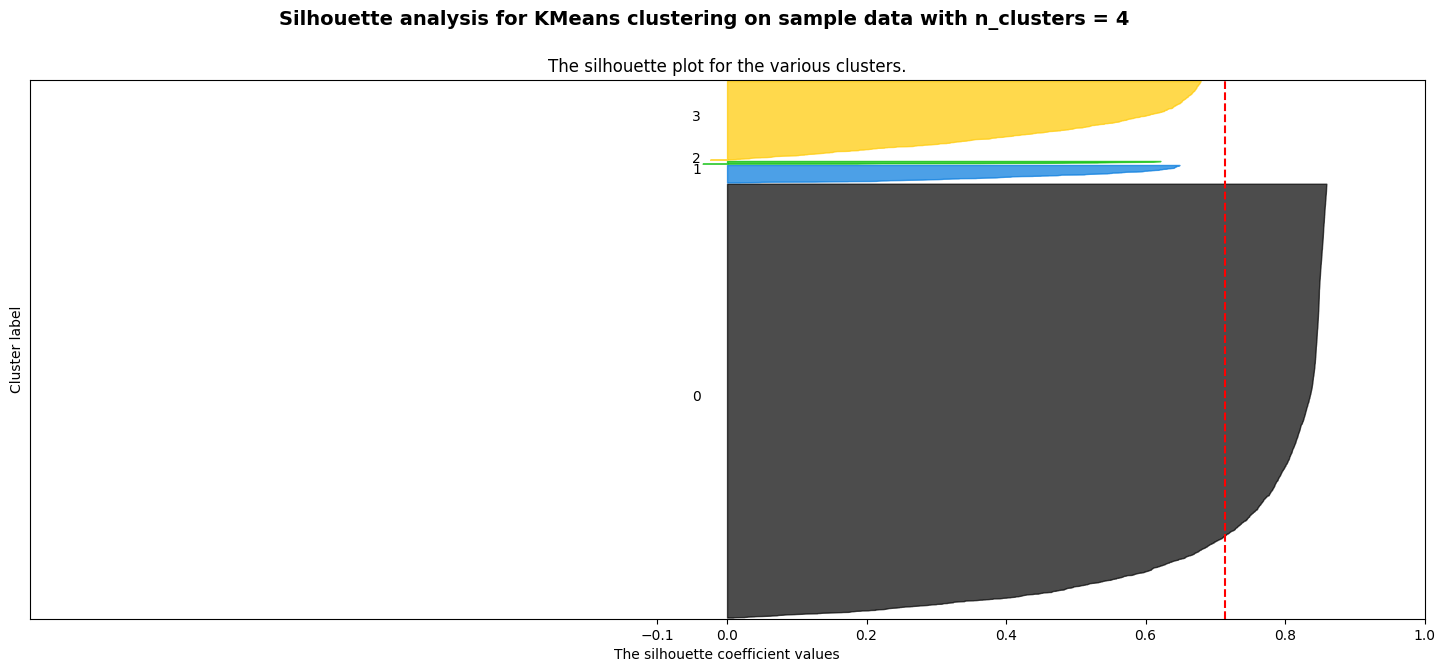

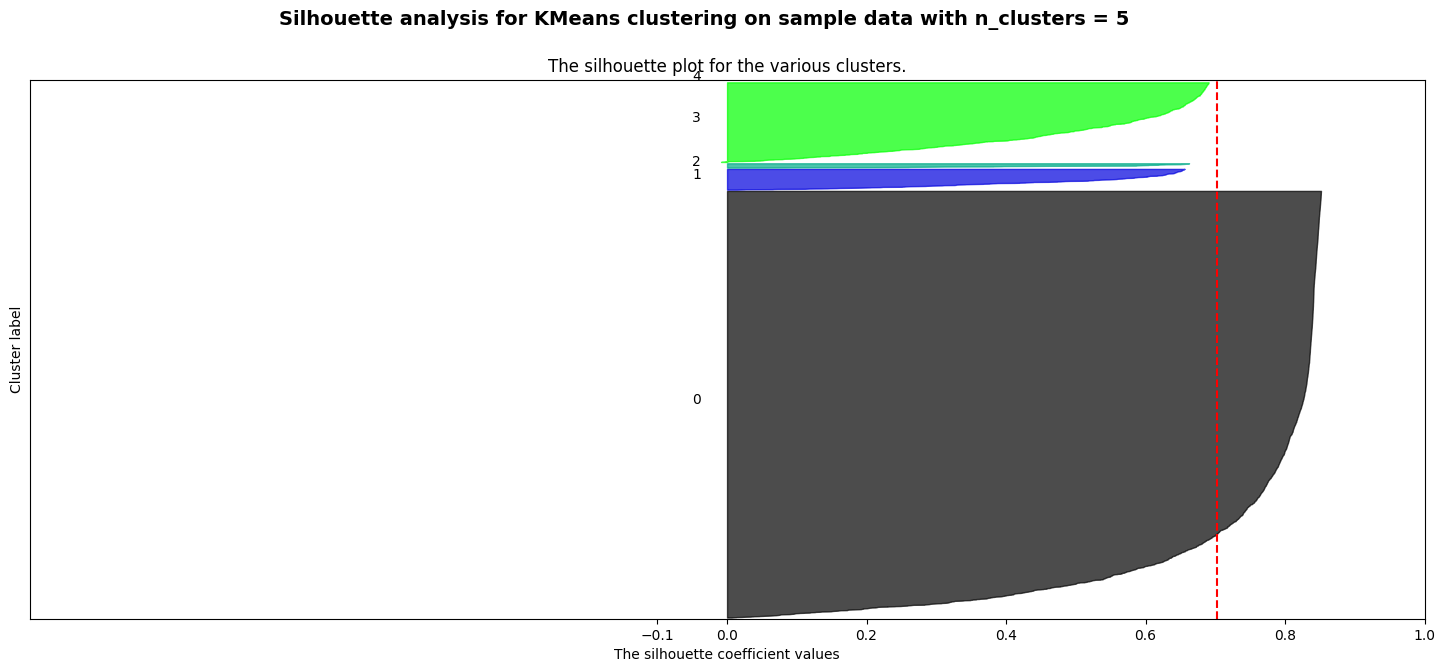

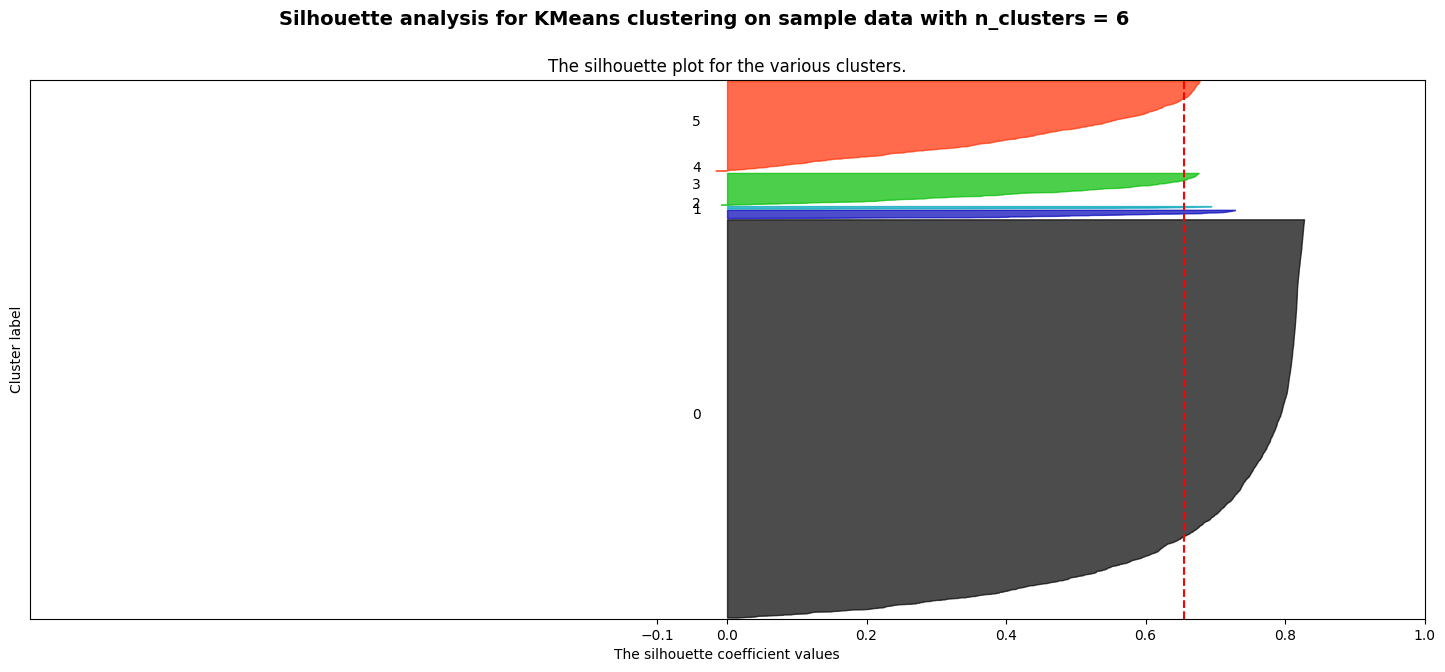

In [ ]:
X=df_clients
range_n_clusters = [2, 3, 4, 5,6] # En este ejemplo determinaos el númnero de clusters a probar de forma manual.

for n_clusters in range_n_clusters:
    # Crea una subparcela con 1 fila y 2 columnas
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # La primera subtrama es la trama de silueta
    # El coeficiente de silueta puede oscilar entre -1, 1
    ax1.set_xlim([-1, 1])
    # El (n_clusters + 1) * 10 es para insertar un espacio en blanco entre la silueta
    # parcelas de conglomerados individuales, para demarcarlas claramente.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Inicialice el clusterer con el valor n_clusters y un generador aleatorio
    # semilla de 10 para reproducibilidad.
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Silhouette_score da el valor promedio de todas las muestras.
    # Esto da una perspectiva de la densidad y separación de la forma
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Calcule las puntuaciones de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)


    y_lower = 10
    for i in range(n_clusters):
        # Agregue las puntuaciones de silueta para muestras pertenecientes a
        # agrupe i, y ordénelos
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquete las parcelas de silueta con sus números de grupo en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcule el nuevo y_lower para la siguiente parcela
        y_lower = y_upper + 10  # 10 para las 0 muestras

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # La línea vertical para la puntuación de silueta promedio de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Borrar las etiquetas / ticks de yaxis
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for Kmeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Transformación de los datos

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
clients_escalados = min_max_scaler.fit_transform(df_clients)
clients_escalados

array([[0.16176471, 0.90909091, 0.5       , ..., 0.        , 0.5       ,
        0.        ],
       [0.20588235, 0.63636364, 0.5       , ..., 0.        , 0.5       ,
        0.        ],
       [0.23529412, 0.36363636, 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.55882353, 0.81818182, 0.5       , ..., 0.20408163, 0.5       ,
        0.        ],
       [0.13235294, 0.09090909, 0.5       , ..., 0.06122449, 0.5       ,
        0.        ],
       [0.36764706, 0.18181818, 1.        , ..., 0.02040816, 1.        ,
        0.        ]])

*clients_scaled* es ahora una matriz de numpy, que no es la misma *estructura de datos* que *df_clients* (que es un dataframe).

Antes de realizar el clustering sería recomendable seleccionar aquellas variables que nos parezcan más significativas para el problema.  Esto es recomendable incluso antes de realizar el procesamiento de los datos, pero esto sólo es posible si conocemos bien el problema de antemano.

Si no conocemos el problema, podemos estudiar cómo se distribuyen esos datos una vez han sido cargados, como por ejemplo, ver la correlación entre variables y/o realizar un **análisis de componentes principales (PCA)** , con el objetivo de detectar si hay algún patrón que nos pueda ayudar a tomar una determinada estrategia, a continuación obtener una proyección 2D de los datos que podamos visualizar y poder así tomar una decisión al respecto.

Reducimos la dimensionalidad de los datos (a dos dimensiones)

In [ ]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(clients_escalados)
# Mostramos el porcentaje de varianza explicada por cada uno de los componentes seleccionados.
print(pca.explained_variance_ratio_)

# Visualizar la "importancia" de cada variable original del problema en las nuevas dimensiones
pd.DataFrame(np.matrix.transpose(pca.components_), columns=['PC-1', 'PC-2'], index=df_clients.columns)

[0.26581448 0.17902466]


,PC-1,PC-2
age,0.031087,0.162126
job,0.118949,-0.047419
marital,0.094035,-0.567374
education,0.085095,-0.086202
default,-0.003230,0.006312
balance,0.003960,-0.000339
housing,-0.811835,-0.403487
loan,-0.032844,0.075057
contact,-0.529899,0.387879
duration,0.004341,-0.005506


Visualizar el dataset utilizando las dos dimensiones obtenidas en el PCA

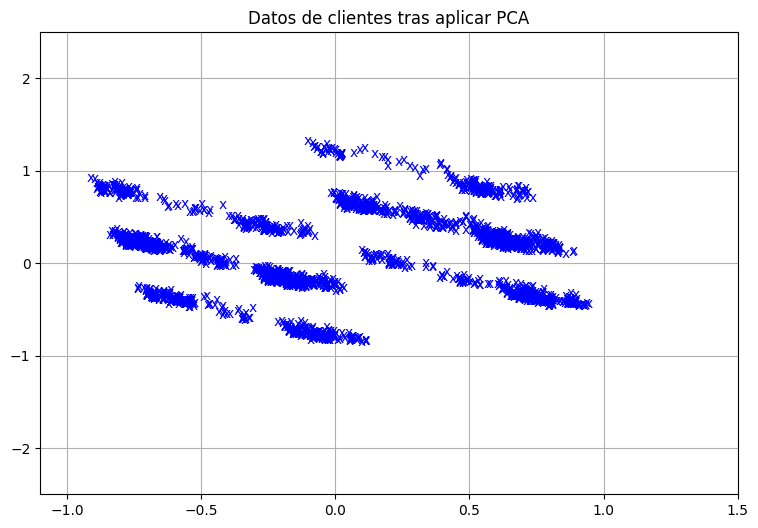

In [ ]:
plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color="b")
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.title("Datos de clientes tras aplicar PCA")
plt.grid()
plt.show()

## Ejecución del algoritmo de clustering jerárquico

A continuación, vamos a ejecutar un algoritmo de clustering jerárquico (notar que tardará un rato en ejecutarse) para ver cómo se distribuyen los datos.

Dado que la mayor parte de los datos no están muy concentrados y el resto parecen valores atípicos, es mejor utilizar como distancia intercluster el **vecino más próximo** (single). Las opciones más recomendadas para este problema van desde el **vecino más alejado** (complete) hasta la **mínima varianza** (ward).

Utilizaremos como distancia el vecino más cercano (single) ya que nos permitirá dividir los grupos más grandes. Se establece un umbral (threshold) de $15$ como distancia a partir de la cual se considerará que los grupos a distancia mayor son grupos independientes (y por lo tanto no se agruparan).

Clustering jerárquico

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


Distancia Media	   1.40


<ipython-input-15-0392b3d434fe>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='single')


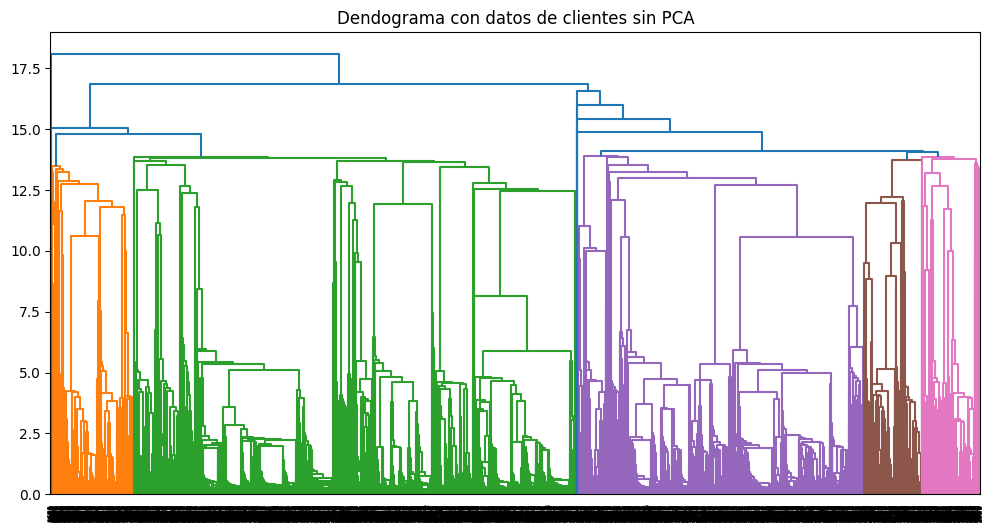

In [ ]:
# 1. Obtener la matriz de distancia entre todos los elementos
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(clients_escalados)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

# 2. Constuimos el dendograma
from scipy import cluster
plt.figure(figsize=(12, 6))
# Seleccionamos como distancia intercluster el vecino más alejado (complete)
# clusters = cluster.hierarchy.linkage(D, method='complete')
clusters = cluster.hierarchy.linkage(D, method='single')
# Cada fila del array clusters representa una fusión específica, indicando
#              * Qué clusters se combinaron (Columna1 y Columna2)
#              * La distancia entre ellos en el momento de su fusión
#              * El tamaño del nuevo cluster resultante.
cluster.hierarchy.dendrogram(clusters, color_threshold=14)
plt.title("Dendograma con datos de clientes sin PCA")
plt.show()

# Para más información consultar:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

Tras realizar el corte con un umbral de $14$, utilizando distancia intercluster el vecino más cercano (single), obtenemos $5$ grupos. Este nivel de corte debe realizarse ad-hoc en un nível que consideremos lógico. Con este umbral he intentado evitar los outiliers, que conformarían grupos de un solo elemento.

A continuación vamos a obtener un vector (*labels*) que, dada una distancia de corte (*threshold*) y un criterio de distancia intercluster, contenga el grupo al que pertece cada elemento.

3. Obtenemos el grupo al que pertenece cada observación

In [ ]:
threshold = 14 # ad-hoc
labels = cluster.hierarchy.fcluster(clusters, threshold , criterion='distance')

# ¿Cuántos grupos hay? Contamos el número de "labels" distintas en el vector
print("Número de clusters {}".format(len(set(labels))))
labels

Número de clusters 11


array([5, 1, 2, ..., 5, 5, 1], dtype=int32)

Ahora podemos volver a representar gráficamente los datos del PCA (en dos dimensiones) pero introduciendo como color los resultados de las etiquetas. Se puede ver que el clustering no ha quedado nada mal, los resultados son coherentes.

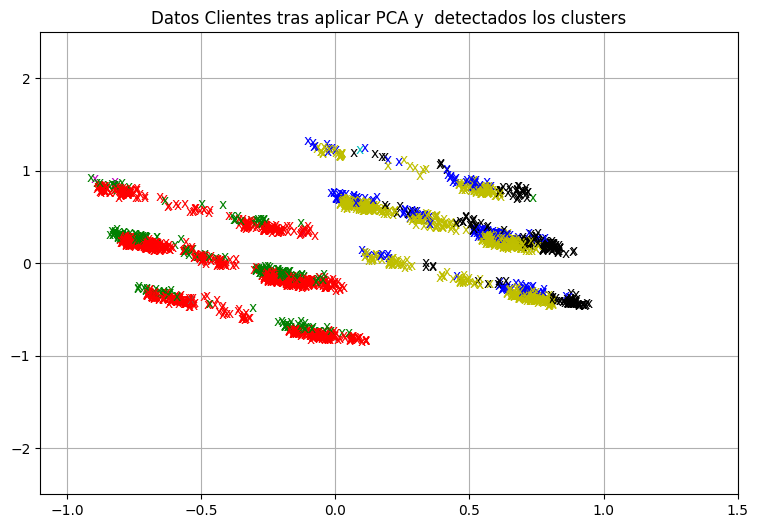

In [ ]:
colores = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colores = np.hstack([colores] * 20)

plt.figure(figsize=(9, 6))
for i in range(len(X_pca)):
    plt.text(X_pca[i][0], X_pca[i][1], 'x', color=colores[labels[i]])
plt.xlim(-1.1, 1.5)
plt.ylim(-2.5, 2.5)
plt.grid()
plt.title("Datos Clientes tras aplicar PCA y  detectados los clusters")
plt.show()

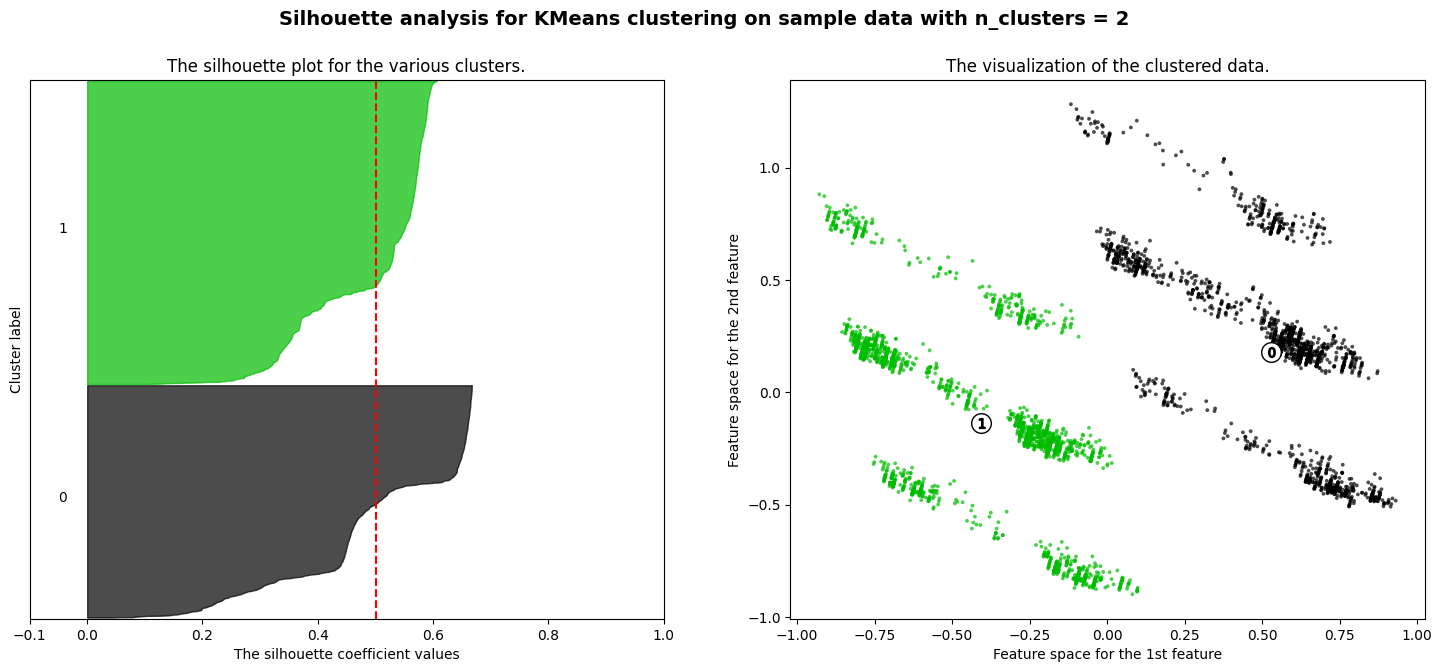

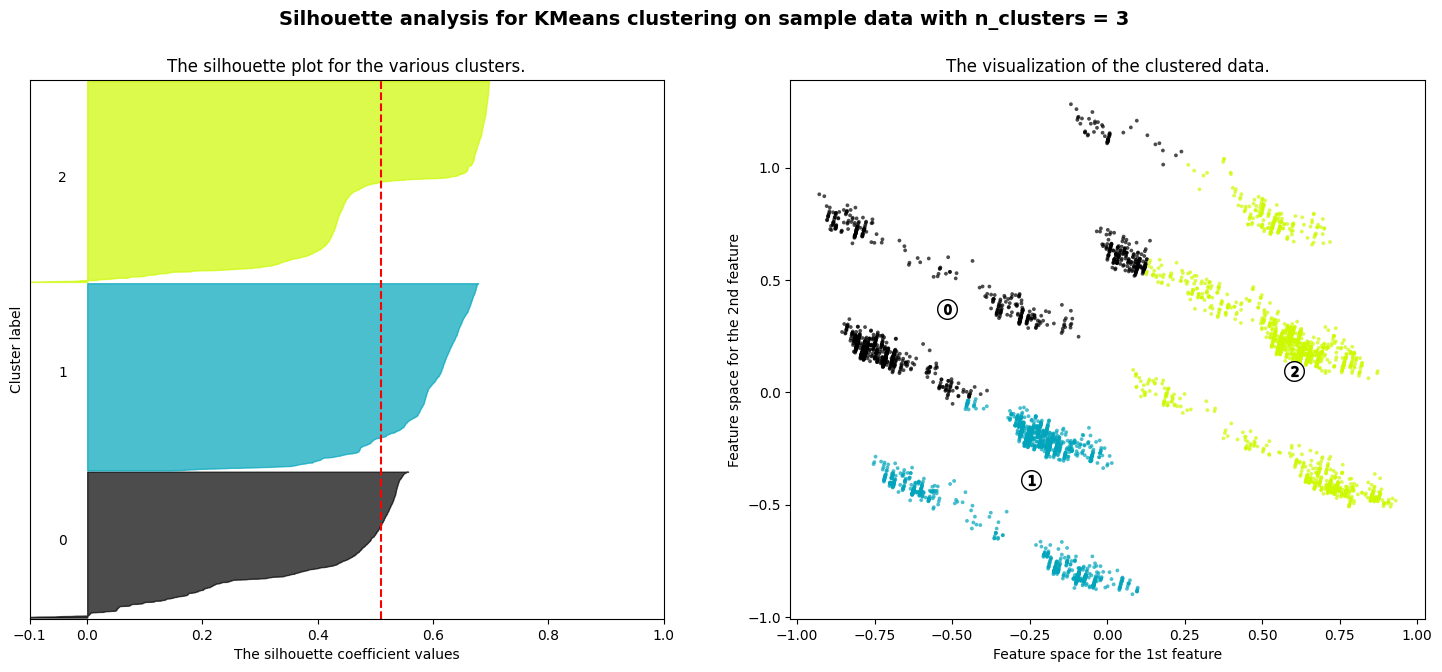

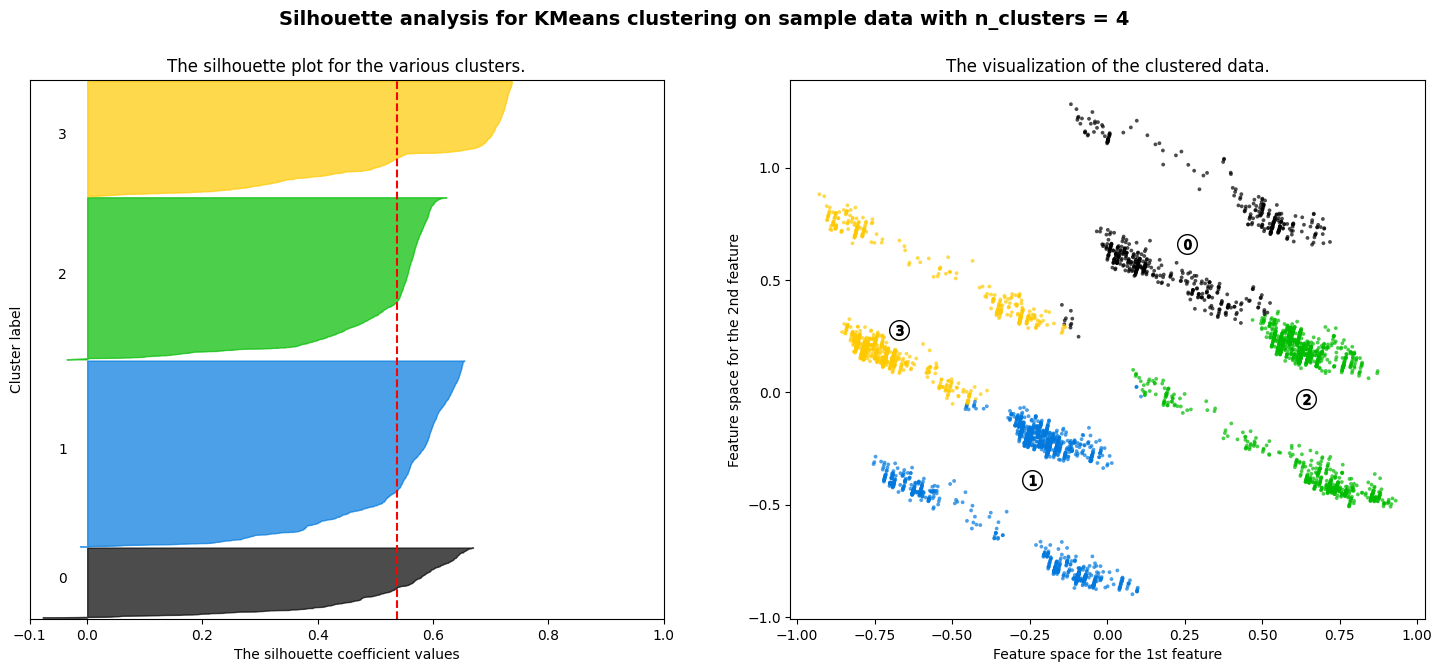

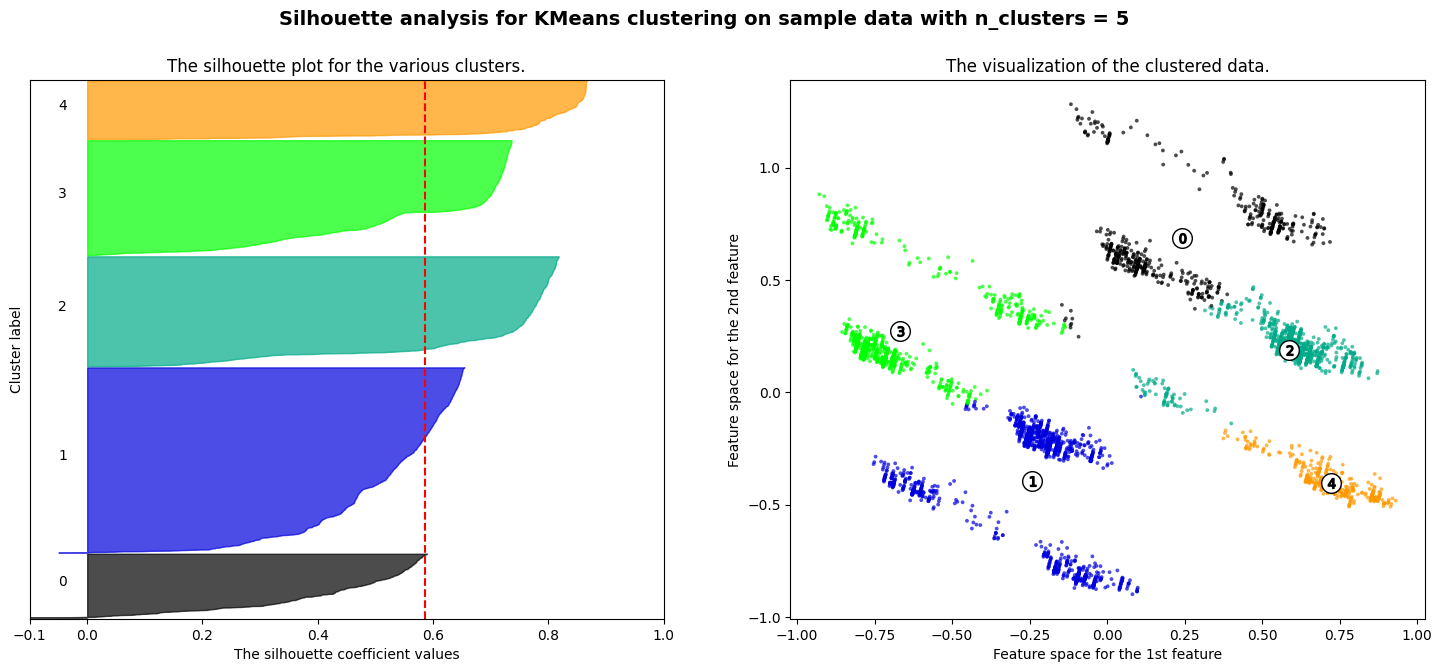

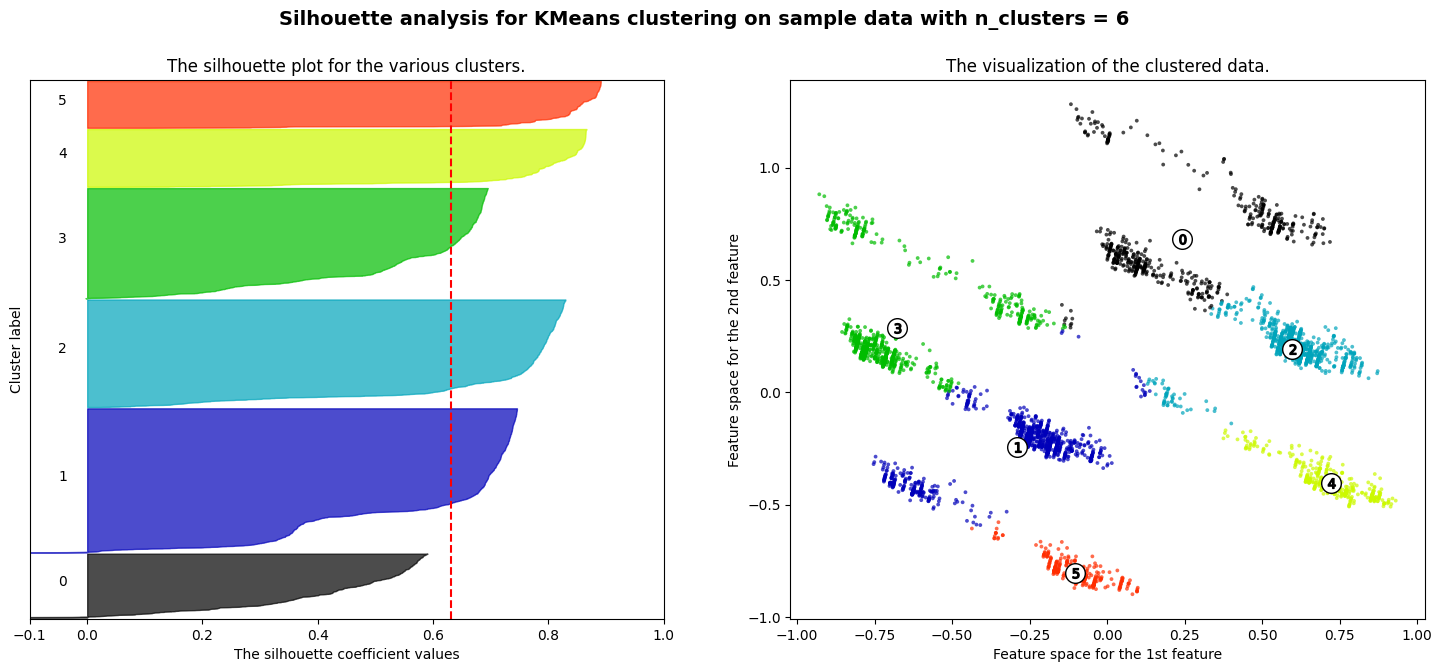

In [ ]:
range_n_clusters = [2, 3, 4, 5,6] # En este ejemplo determinamos el número de clusters a probar de forma manual.

for n_clusters in range_n_clusters:
    # Crea una subparcela con 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # La primera subtrama es la trama de silueta
    # El coeficiente de silueta puede oscilar entre -1, 1 pero en este ejemplo todos
    # se encuentran dentro de [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # El (n_clusters + 1) * 10 es para insertar un espacio en blanco entre la silueta
    # parcelas de conglomerados individuales, para demarcarlas claramente.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])



    # Inicialice el clusterer con el valor n_clusters y un generador aleatorio
    # semilla de 10 para reproducibilidad.
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto', random_state=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # Silhouette_score da el valor promedio de todas las muestras.
    # Esto da una perspectiva de la densidad y separación de la forma
    # clusters
    '''  silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    '''
    # Calcule las puntuaciones de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)


    y_lower = 10
    for i in range(n_clusters):
        # Agregue las puntuaciones de silueta para muestras pertenecientes a
        # agrupe i, y ordénelos
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquete las parcelas de silueta con sus números de grupo en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcule el nuevo y_lower para la siguiente parcela
        y_lower = y_upper + 10  # 10 para las 0 muestras

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # La línea vertical para la puntuación de silueta promedio de todos los valores
    # Silhouette_avg da el valor promedio de todas las muestras.
    # Esto da una perspectiva de la densidad y separación de la forma

    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Borrar las etiquetas / ticks de yaxis
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2do Gráfico que muestra los grupos reales formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Etiquetado de los clusters
    centers = clusterer.cluster_centers_
    # Dibuja círculos blancos en los centros de los grupos
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


# Entrenamiento con K-means

Utilizo 2 clústers, porque es la única gráfica "limpia", en la que no se ve ninguna parte de la línea en negativo, que significaría inseguridad a la hora de incluir algún registro en un determinado clúster.

In [ ]:
def entrenar_KMeans(X,clusters):
  kmeans = KMeans(n_clusters = clusters,  n_init='auto',random_state = 0)
  kmeans.fit(X)
  preds = kmeans.predict(X)
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, marker = '+', c = 'black', label = 'Centro')
  labels_kmeans=kmeans.labels_
  return labels_kmeans, preds

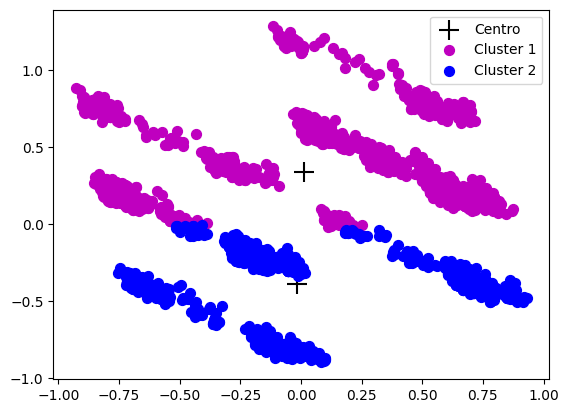

In [ ]:
labels, preds= entrenar_KMeans(X_pca, 2)
cores = ['m', 'b']
for i in range(len(cores)):
    plt.scatter(X_pca[preds == i, 0], X_pca[preds == i, 1], s = 50, c = cores[i], label = 'Cluster ' + str(i + 1))

#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 200, marker = '+', c = 'black', label = 'Centro')
plt.legend()
plt.show()

In [ ]:
def obtener_indice_dunn(X, labels):

  # Calcular la matriz de distancias entre los puntos
  pairwise_distances = squareform(pdist(X))
  unique_labels = np.unique(labels)

  # Calcular el diámetro máximo de los clusters
  max_intra_cluster_diameter = np.max([np.max(pairwise_distances[labels == i][:, labels == i])
                                        for i in unique_labels if np.sum(labels == i) > 1])
  # Calcular la distancia mínima entre clusters
  min_inter_cluster_distances = np.min([np.min(pairwise_distances[labels == i][:, labels == j])
                                        for i in range(len(unique_labels))
                                        for j in range(i+1, len(unique_labels))
                                        if np.sum(labels == i) > 0 and np.sum(labels == j) > 0])
  # Calcular el índice de Dunn
  dunn_index = min_inter_cluster_distances / max_intra_cluster_diameter
  return dunn_index

Índice  de Dunn sin  PCA:   0.0324
--- Entrenamiento K Means sin reducción dimensionalidad ---
Índice  de Dunn para k = 2: 0.3678
Silhouette Score for k = 2: 0.2534
Índice  de Dunn para k = 3: 0.3794
Silhouette Score for k = 3: 0.2649
Índice  de Dunn para k = 4: 0.1457
Silhouette Score for k = 4: 0.2546
Índice  de Dunn para k = 5: 0.0783
Silhouette Score for k = 5: 0.2741
Índice  de Dunn para k = 6: 0.0822
Silhouette Score for k = 6: 0.2740
Índice  de Dunn para k = 7: 0.1135
Silhouette Score for k = 7: 0.2643
Índice  de Dunn para k = 8: 0.1135
Silhouette Score for k = 8: 0.2944
Índice  de Dunn para k = 9: 0.1203
Silhouette Score for k = 9: 0.3087
Índice  de Dunn para k = 10: 0.1203
Silhouette Score for k = 10: 0.3214
Índice  de Dunn para k = 11: 0.1187
Silhouette Score for k = 11: 0.3231
Índice  de Dunn para k = 12: 0.1674
Silhouette Score for k = 12: 0.3107
Índice  de Dunn para k = 13: 0.1237
Silhouette Score for k = 13: 0.3262
Índice  de Dunn para k = 14: 0.0403
Silhouette Score for 

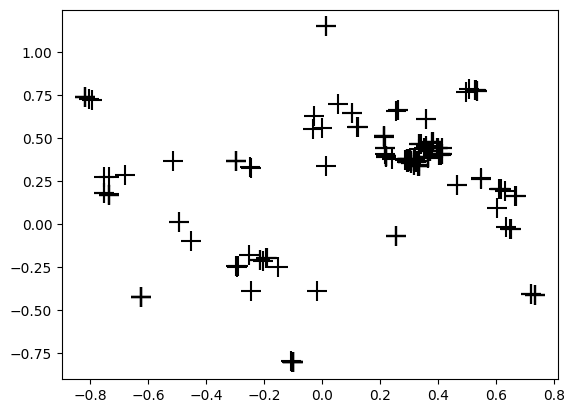

In [ ]:
indice_datos_escalados=obtener_indice_dunn(clients_escalados,labels)


print ('Índice  de Dunn sin  PCA:   {:<.4f}'.format(indice_datos_escalados)) # clusters sugeridos por el dendograma

# Establemecemos un límite para realizar una prospección del coeficiente de Silueta (silhouette score)
limit = 15
print ('--- Entrenamiento K Means sin reducción dimensionalidad ---')
for k in range(2, limit + 1):
    labels, preds = entrenar_KMeans(clients_escalados,k)
    indice = obtener_indice_dunn(clients_escalados, labels)
    score = silhouette_score(clients_escalados, preds)
    print('Índice  de Dunn para k = {}: {:<.4f}'.format(k, indice))
    print('Silhouette Score for k = {}: {:<.4f}'.format(k, score))

print ('--- Entrenamiento K Means sin con PCA ---')
for k in range(2, limit + 1):
    labels, preds = entrenar_KMeans(X_pca,k)
    indice = obtener_indice_dunn(X_pca, labels)
    score = silhouette_score(X_pca, preds)
    print('Índice  de Dunn para k = {}: {:<.4f}'.format(k, indice))
    print('Silhouette Score for k = {}: {:<.4f}'.format(k, score))

# Cuanto más alto es el score mejor agrupamiento cluster obtendremos

Entreno Kmeans con 3 clusters para el dataset sin reducir dimensionalidad y 11
 clusters para el dataset al que le he aplicacdo PCA, tomo los clusters de los mejores indices de las métricas obtenidas.

In [ ]:
labels, preds = entrenar_KMeans(clients_escalados,3)
nueva_columna = np.array(preds)
# Añadir la nueva columna a la última posición del array
clients_escalados=np.append(clients_escalados, nueva_columna[:, np.newaxis], axis=1)

labels, preds = entrenar_KMeans(X_pca,11)
nueva_columna = np.array(preds)
# Añadir la nueva columna a la última posición del array
X_pca=np.append(X_pca,nueva_columna[:, np.newaxis], axis = 1)

# DBSCAN sin reducción de la dimensionalidad

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=70)
clusters_DBSCAN = dbscan.fit_predict(clients_escalados)

# Número de clusters obtenidos
set (clusters_DBSCAN)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

# DBSCAN + PCA

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=25)
clusters_DBSCAN_pca = dbscan.fit_predict(X_pca)

# Número de clusters obtenidos
set (clusters_DBSCAN_pca)

{0}

# DPC sin reducción de la dimensionalidad


In [ ]:
def DPC (data):
  # Transforma tus datos a un array de numpy


  # Inicializa el objeto DPC con los parámetros deseados
  dpc = dpc.DPC( min_pts=50)

  # Aplica DPC a tus datos
  labels = dpc.fit_predict(data)
  preds = dpc.predict(data)
  return labels


In [ ]:
labels_DPC, preds_DPC = DPC(clients_escalados)

UnboundLocalError: local variable 'dpc' referenced before assignment

# DPC + PCA

In [ ]:
labels_DPC_PCA, preds_DPC_PCA = DPC(X_PCA)

# Exportar datos a excel

In [ ]:
# Creación del Dataframe a exportar
df_export_escalados = pd.DataFrame(clients_escalados)
df_export_pca = pd.DataFrame(X_pca)
output_escalados = 'Kmeans_sin_pca.xlsx'
output_pca = 'Kmeans_con_pca.xlsx'

# Exporta los datos a un archivo de Excel
df_export_escalados.to_excel(output_escalados, index=False)
df_export_pca.to_excel(output_pca, index=False)

# Descarga el archivo de Excel a tu computadora local
files.download(output_escalados)
files.download(output_pca)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>